<a href="https://colab.research.google.com/github/01PrathamS/CRUD/blob/master/inception_3_500_crop_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchinfo import summary
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from PIL import Image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
## image transformation as per inception V3_model
manual_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = r'/content/drive/MyDrive/New folder/train'
test_dir = r'/content/drive/MyDrive/New folder/test'

train_data = datasets.ImageFolder(root=train_dir, transform=manual_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=manual_transform)

class_names = train_data.classes

train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count()
)

print(len(train_dataloader), len(test_dataloader), len(class_names))


108 13 7


In [ ]:

weights = models.Inception_V3_Weights.DEFAULT
# model = torchvision.models.inception_v3(weights=weights)
model = torchvision.models.inception_v3(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 258MB/s] 


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.aux_logits = False

for parameter in model.parameters():
  parameter.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 7)
).to(device)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          test_pred_logits = model(X)
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
  return results

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device
                )

end = timer()
print(f'{end-start_time}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1996 | train_acc: 0.6189 | test_loss: 0.6991 | test_acc: 0.8293
Epoch: 2 | train_loss: 0.7319 | train_acc: 0.7770 | test_loss: 0.4780 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.6412 | train_acc: 0.7850 | test_loss: 0.4464 | test_acc: 0.8534
Epoch: 4 | train_loss: 0.5684 | train_acc: 0.8146 | test_loss: 0.3745 | test_acc: 0.8918
Epoch: 5 | train_loss: 0.5427 | train_acc: 0.8067 | test_loss: 0.4060 | test_acc: 0.8750
Epoch: 6 | train_loss: 0.5039 | train_acc: 0.8354 | test_loss: 0.3702 | test_acc: 0.8654
Epoch: 7 | train_loss: 0.5130 | train_acc: 0.8169 | test_loss: 0.4177 | test_acc: 0.8702
Epoch: 8 | train_loss: 0.4828 | train_acc: 0.8322 | test_loss: 0.3400 | test_acc: 0.8894
Epoch: 9 | train_loss: 0.4665 | train_acc: 0.8387 | test_loss: 0.3126 | test_acc: 0.8702
Epoch: 10 | train_loss: 0.4471 | train_acc: 0.8433 | test_loss: 0.3121 | test_acc: 0.8966
3601.918749964


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "inception_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/MyDrive/models/inception_1.pth


tensor(0.9931, device='cuda:0')


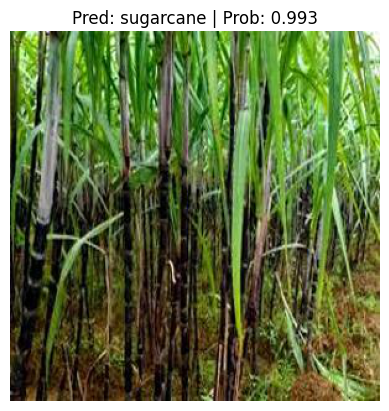

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_img(img_path):


  img = Image.open(img_path)

  model.eval()

  model.to(device)

  with torch.no_grad():
    transformed_img = manual_transform(img).unsqueeze(dim=0).to(device)

    target_img = model(transformed_img)

  target_img_pred = torch.softmax(target_img, dim=1)

  print(target_img_pred.max())

  if (target_img_pred.max()) > torch.tensor(0.80):


    target_img_label = torch.argmax(target_img_pred, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_img_label]} | Prob: {target_img_pred.max():.3f}")
    plt.axis(False);

  else:
    print('not valid')

predict_img('/content/drive/MyDrive/New folder/train/sugarcane/sugarcane_385.png')

In [ ]:
{'inception_0':'''Epoch: 1 | train_loss: 1.1996 | train_acc: 0.6189 | test_loss: 0.6991 | test_acc: 0.8293
Epoch: 2 | train_loss: 0.7319 | train_acc: 0.7770 | test_loss: 0.4780 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.6412 | train_acc: 0.7850 | test_loss: 0.4464 | test_acc: 0.8534
Epoch: 4 | train_loss: 0.5684 | train_acc: 0.8146 | test_loss: 0.3745 | test_acc: 0.8918
Epoch: 5 | train_loss: 0.5427 | train_acc: 0.8067 | test_loss: 0.4060 | test_acc: 0.8750'''}

{'inception_1': '''Epoch: 1 | train_loss: 1.1996 | train_acc: 0.6189 | test_loss: 0.6991 | test_acc: 0.8293
Epoch: 2 | train_loss: 0.7319 | train_acc: 0.7770 | test_loss: 0.4780 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.6412 | train_acc: 0.7850 | test_loss: 0.4464 | test_acc: 0.8534
Epoch: 4 | train_loss: 0.5684 | train_acc: 0.8146 | test_loss: 0.3745 | test_acc: 0.8918
Epoch: 5 | train_loss: 0.5427 | train_acc: 0.8067 | test_loss: 0.4060 | test_acc: 0.8750
Epoch: 6 | train_loss: 0.5039 | train_acc: 0.8354 | test_loss: 0.3702 | test_acc: 0.8654
Epoch: 7 | train_loss: 0.5130 | train_acc: 0.8169 | test_loss: 0.4177 | test_acc: 0.8702
Epoch: 8 | train_loss: 0.4828 | train_acc: 0.8322 | test_loss: 0.3400 | test_acc: 0.8894
Epoch: 9 | train_loss: 0.4665 | train_acc: 0.8387 | test_loss: 0.3126 | test_acc: 0.8702
Epoch: 10 | train_loss: 0.4471 | train_acc: 0.8433 | test_loss: 0.3121 | test_acc: 0.8966
3601.918749964'''}

In [ ]:
def predict(img) -> Tuple[Dict, float]:
    start_time = timer()
    img = manual_transform(img).unsqueeze(0).to(device)
    torch.cuda.manual_seed(42)
    torch.manual_seed(42)
    model.eval()
    model.to(device)
    with torch.inference_mode():
        pred_probs = torch.softmax(model(img), dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

example_list = [
                ['/content/sugarcane_4.png'],
               ]

title = "Crop Identification model_1"
description = "cotton, castor, bajra,groundnut, sugarcane, paddy, wheat"
article = "Trained a model on custom data using transfer learning [model : Inception_V3]"


demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=7, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)


demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c5147de2e20829e807.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
